# Obtaining financial data

This notebook explains how to obtain high-quality price data at daily frequency from US listed stocks.

In [5]:
from IPython.display import Image
import datetime
import contextlib
from typing import Generator
import wrds

## Getting data: WRDS, CRSP and tickers for the S&P 500 universe.

For this project, we make use of `CRSP` data. 

The acronym `CRSP` stands for `Center for Research in Security Prices` and you can find more information about them here: https://www.crsp.org/
They are a respected data provider that are behind a paywall. Unfortunately, high-quality financial data is known to be unaffordably expensive, but luckily Imperial College has a license. Precisely, you can access `CRSP` data via `WRDS`, being short for `Wharton Research Data Services`. WRDS understand themselves to be "the global standard for business research". We will not question the details of this statement, but they certainly do offer data that you also can make use for you university projects and dissertation all the way up to PhD and Postdoc research. You can find more information about them here: https://wrds-www.wharton.upenn.edu. 

In order to access `CRSP` data via `WRDS`, you need to follow these steps: 

1) Apply for a `WRDS` account via Imperial College's library services here:
https://www.imperial.ac.uk/admin-services/library/subject-support/business/wrds/

2) Log on your `WRDS` account:
https://wrds-www.wharton.upenn.edu/login/

3) Upon logging in, you will see a menu that looks like the following. Click on `CRSP`.

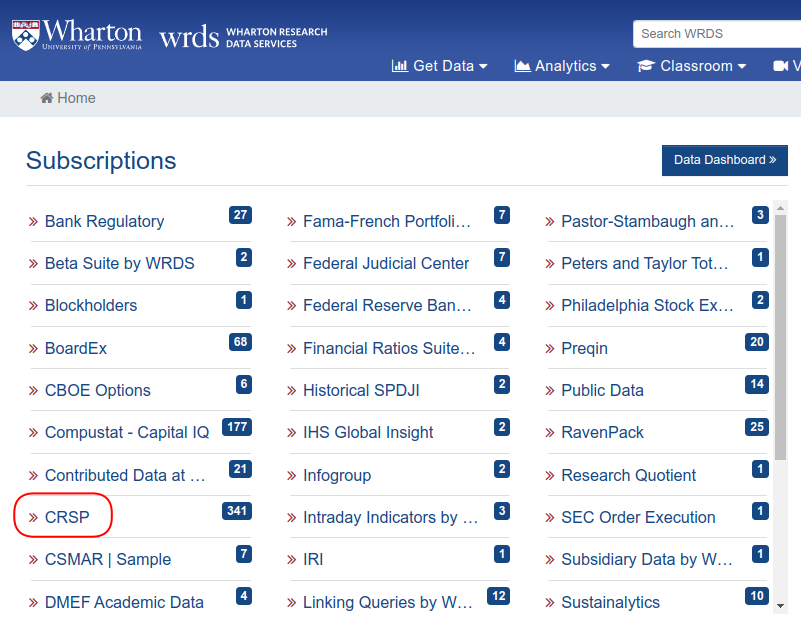

In [6]:
Image(filename="./../figures/WRDS_overview.png")

4) Under `Quarterly Update`, click on `Stock - Version 2`.

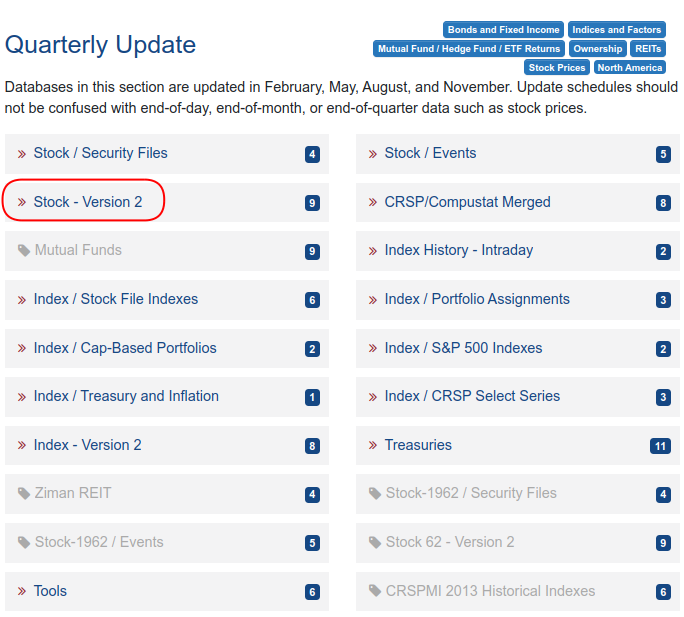

In [7]:
Image(filename="./../figures/CRSP1_select_quarterly.png")

5) Under `Stock - Version 2`, click on `Daily Stock File`.

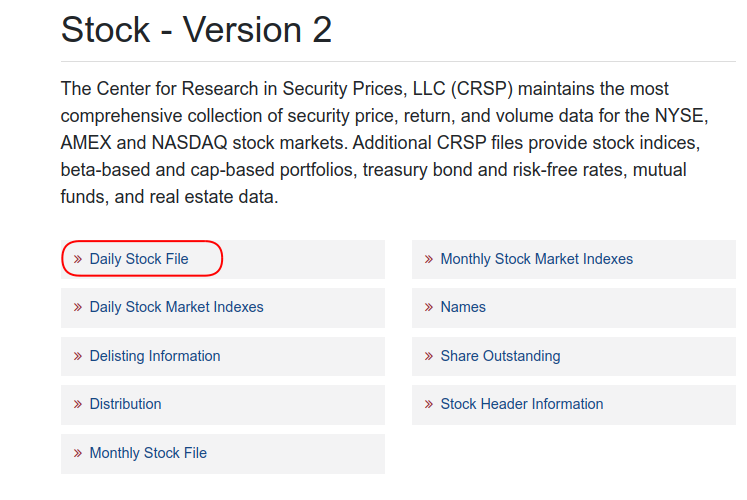

In [8]:
Image(filename="./../figures/CRSP2.png")

Finally, you can see a mask that allows you to select a **date range** of your choosing. For this exemplar, I go all the way back from `1980-01-01` to the most recent date available at the time of writing, `2023-12-29`. 

Below, see a mask to select the format of the identifier of the stock, or **company codes**, you wish to query data for. I suggest using `Ticker (ticker)`. 

        To help, you will find a list of tickers for the S&P 500 components as of the end of 2023 in the text file `data/SP500_tickers_one_per_line.txt` in the file directory of this exemplar. If you work for a bank or financial institution, they will ususlly have an *Operations* team that tracks any tickers at any exchange they trade on. Tickers, as well as index components can change in time, as members will be included and others excluded from an index. Hence, the composition of the ticker list can change. I obtained the tickers from https://www.slickcharts.com/sp500 on 4 December 2023, which is a public available source. I encourage you to get this data from the web, comparing them to the tickers contained and updating any changes.

Now back to WRDS. If you want to query data for more than one stock, upload the file mentioned above using the *Upload a plain text file (.txt), having one code per line* option.

You can then go ahead and select the **query variables** you wish to query for each of the tickers. For the purpose of this exemplar, we need to obtain the following:
* Daily Price (DlyPrc)
* Daily Open (DlyOpen)
* Daily High (DlyHigh)
* Daily Low (DlyLow)
* Daily Close (DlyClose)
* Daily Volume (DlyVol)
* Daily Price Volume (DlyPrcVol)


You can choose the output file format, and compression options, which is suggested for larger data requests. For this exemplar we use `CSV` compressed as  `gzip` with dates formatted as `YYYY-MM-DD`.

Clicking on `Submit Form` will query the data, taking you to a window that will eventually provide a download link for your data. If notifications are configured, you can receive an email notifying you once the process is complete. With this data you can progress importing it to the program of choice to conduct your research on the data.

For other ways to query data through WRDS, see below, otherwise move through the rest of this exemplar.

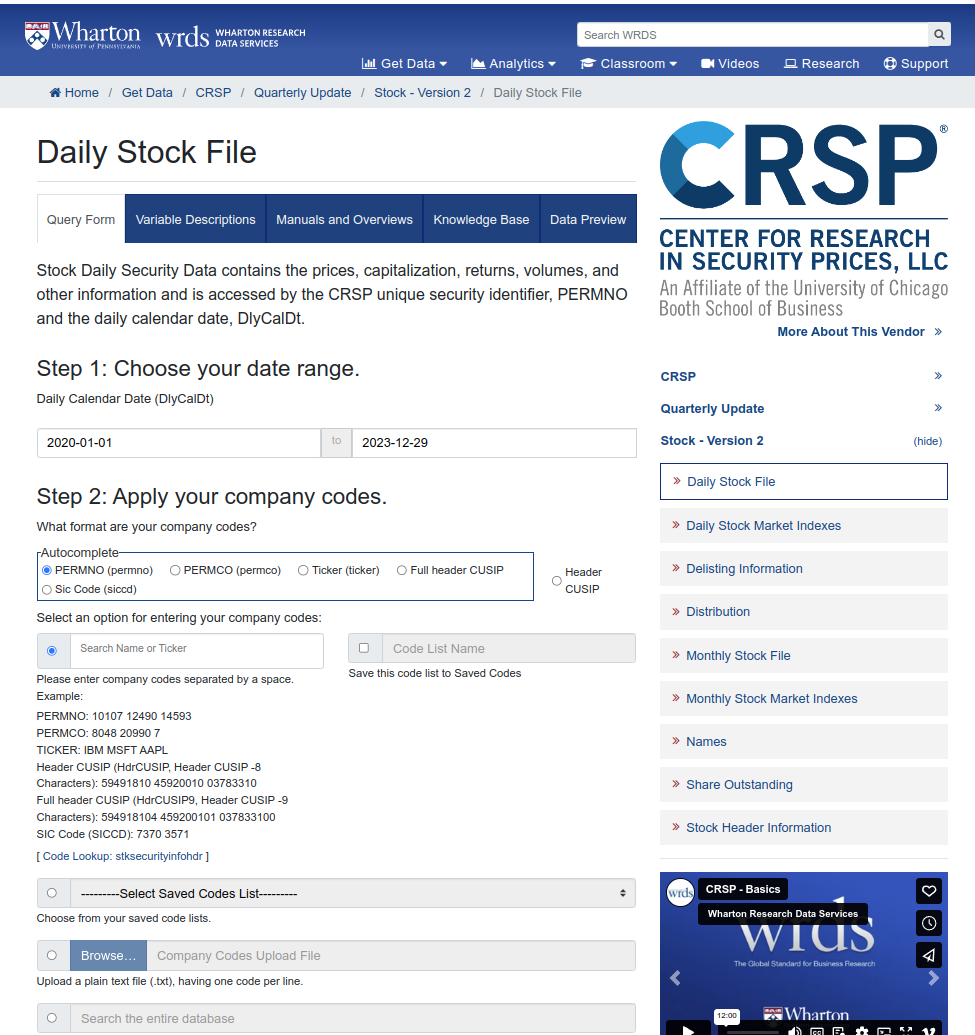

In [9]:
Image(filename="./../figures/CRSP3_select_data.png")

## Querying `WRDS` data directly from within `Python`

Alternatively, you can also query data directly from within Python using `WRDS's` PyPi indexed Python package `wrds` that you can install using `pip install wrds`. The sample script below shows how you can set up a connection and query data from `MSFT` and `AAPL` using `SQL` commands. 

```
!pip install wrds  # https://pypi.org/project/wrds/
import wrds
db = wrds.Connection(wrds_username='your_individually_assigned_username')  # input your credential

print(db.list_libraries())  # prints accessible data sets

sql_query =\
"""
SELECT permno, date, prc, vol, askhi, bidlo
FROM crsp.dsf
WHERE permno IN (10107, 14593) -- Example PERMNOs for Microsoft and Apple
AND date >= '2020-01-01' AND date <= '2020-12-31';
"""
data = db.raw_sql(sql_query)
```

# Appendix

As discussed, relying solely on the ticker list for future reference has its limitations. S&P 500 membership can change over time, companies can undergo name changes (e.g., Facebook to Meta), and ticker symbols can also change.

A more robust approach involves using the `permanent company number (permno)`, which uniquely identifies a listed company. This method allows us to programmatically track the S&P 500 constituents over time. To illustrate, we will retrieve the index members as of the most recent date for which our academic license provides data, which is 29 December 2023 at the time of writing. The following section will detail how to programmatically obtain the members for that day.

We employ SQL commands to access WRDS's database, which documents the S&P 500 index's membership changes in time. This approach produces a DataFrame detailing the index's constituents from its inception. By concentrating on the most recent data available, we opt for using permnos over tickers for retrieving price information. This strategy increases the accuracy of identifying index members, offering a more reliable alternative to open-source data. Our preference for commercial data sources like WRDS over open-source options is driven not by a dismissal of the latter, but by the higher quality control standards and accountability typically associated with commercial datasets.

As an aside, this dataset opens up several avenues for analysis regarding the index's evolution over time that you can investigate in your own time. Consider, for example, ranking the members by their tenure in the index to explore their trajectories through various economic boom and bust cycles. It could also be enlightening to identify which periods were the most dynamic in terms of membership changes. Additionally, examining the newest members of the index may offer insights into shifting trends and sectors within the broader economy. 

In [13]:
# when working with databases, it is of crucial importance to close the connection one we are done.
# Invoking db.close() would do, but this is easily forgotten. Hence, we make use of a context manager which takes
# care of this issue automatically for us. We can use the contextmanager decorator to obtain this behaviour.


@contextlib.contextmanager
def wrds_connection(wrds_username: str) -> Generator[wrds.Connection, None, None]:
    db = None
    try:
        db = wrds.Connection(wrds_username=wrds_username)
        yield db
    finally:
        if db is not None:
            db.close()

In [14]:
# this will be the SQL query we run. Going into details regarding the language is beyon the scope, however,
# it is a reasonably human-readable language.

START_DATE = "1900-01-01"
END_DATE = "2023-12-29"

splist_query = """
SELECT *
FROM crsp.dsp500list
WHERE ending >= %(start_date)s AND ending <= %(end_date)s;
"""

In order to execute the below cell, you need to pass your `wrds_username` as an argument.

In [15]:
# using the context manager for secure and clean database connection handling.
# Also take care to use your very own wrds_username that was assigned to you oce you applied for a WRDS account
# and call the below with wrds_connection(wrds_username='your_individually_assigned_username')

with wrds_connection(wrds_username="YOUR_WRDS_USERNAME") as db:
    splist_data = db.raw_sql(
        splist_query, params={"start_date": START_DATE, "end_date": END_DATE}
    )

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [17]:
# filtering the data for the specific date for which we need the S&P500 components
splist_data = (
    splist_data[
        splist_data["ending"] == datetime.datetime.strptime(END_DATE, "%Y-%m-%d").date()
    ]
    .sort_values(by="start")
    .reset_index(drop=True)
)

splist_data

,permno,start,ending
0,14541,1925-12-31,2023-12-29
1,15069,1925-12-31,2023-12-29
2,10145,1925-12-31,2023-12-29
3,21573,1925-12-31,2023-12-29
4,11404,1925-12-31,2023-12-29
...,...,...,...
498,32942,2023-10-18,2023-12-29
499,92203,2023-10-18,2023-12-29
500,90720,2023-12-18,2023-12-29
501,18576,2023-12-18,2023-12-29


# END